In [54]:
# Misc
import os 
import sys
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import networkx as nx
from tqdm import tqdm
from torch_geometric.utils import convert
from torch_geometric.data import InMemoryDataset, download_url, Data, Dataset
from torch_geometric.loader import DataLoader
from torch.nn import Linear
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.nn import global_mean_pool, global_max_pool
from itertools import cycle


from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler



In [28]:
# Load in label by name
def get_label(file, labels):
    pair_1 = file.split('/')[-1]
    pair_1, pair_2 = pair_1.split("and")
    pair_1 = pair_1.replace(".gpickle", "")
    pair_2 = pair_2.replace(".gpickle", "")
    l = int(labels.loc[(labels.protein_1 == pair_1) & (labels.protein_2 == pair_2)].label)
    return file, l

def read_graphs(file_set):
    g_list = []
    for i, file in enumerate(file_set):
        G = nx.read_gpickle(file)
        g_list.append(G)
    return g_list
    
def format_graphs(graphs, label=1):
    graph_list = []
    # Convert into pytorch geoetric dataset: Positive
    for i, x in enumerate(tqdm(graphs)):
        F = nx.convert_node_labels_to_integers(x)
        for (n1, n2, d) in F.edges(data=True):
            d.clear()
        data = convert.from_networkx(F, group_edge_attrs=None)
        data.y = torch.FloatTensor(np.array([label]))
        graph_list.append(data)
    return graph_list

def binary_acc(y_pred, y_test):
    probas = torch.sigmoid(y_pred)
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc, y_pred_tag, probas

class MyDataset(Dataset):
    def __init__(self, datasetA, datasetB):
        self.datasetA = datasetA
        self.datasetB = datasetB
        
    def __getitem__(self, index):
        xA = self.datasetA[index]
        xB = self.datasetB[index]
        return xA, xB
    
    def __len__(self):
        return len(self.datasetA)

# Develop model structure
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels=64):
        """
        This class takes in 2 inputs. Each input is a graph representing a single protein structure in a protein pair.
        Each graph is processed by seperate nerual networks, the outputs of which are then concatenated into a single
        hiddden state. Finally this hidden state is passed through a simple dense layer for feature extraction, and then 
        returned for use with a BCEWithLogitLoss (recommended for binary classificatio) method inside the main training loop.

        :param hidden_channels: the number of hidden neurons to use, defaults to 64
        :type hidden_channels: int, optional

        """
        super(GCN, self).__init__()

        # Parameters
        self.num_node_features = 16
        self.num_classes = 1
        self.hidden_channels = hidden_channels

        #### Graph 1 ####
        # Layers (consider using class SAGEConv instead)
        self.g1_conv_1 = GATConv(self.num_node_features, self.hidden_channels, heads=2)
        self.g1_linear_1 = Linear(self.hidden_channels, self.hidden_channels)

        # Paramteric RelU (prelu)
        self.g1_act_1 = torch.nn.ELU()
        self.g1_act_2 = torch.nn.ELU()

        #### Graph 2 ####
        self.g2_conv_1 = GATConv(self.num_node_features, self.hidden_channels, heads=2)
        self.g2_linear_1 = Linear(self.hidden_channels, self.hidden_channels)
        self.g2_act_1 = torch.nn.ELU()
        self.g2_act_2 = torch.nn.ELU()

        #### Concatenated graphs ####
        self.cat_linear = Linear(self.hidden_channels * 2, self.num_classes)
        self.cat_act = torch.nn.ELU()


    def forward(self, x_1, x_2, edge_index_1, edge_index_2, batch_1, batch_2):

        #### Graph 1 ####
        # Conv block graph 1
        x_1 = self.g1_conv_1(x_1, edge_index_1)
        x_1 = global_max_pool(x_1, batch_1) 
        x_1 = self.g1_act_1(x_1)
        
        # Linear block graph 1
        x_1 = self.g1_linear_1(x_1)
        x_1 = self.g1_act_2(x_1)


        #### Graph 2 ####
        # Conv block graph 2
        x_2 = self.g2_conv_1(x_2, edge_index_2)
        x_2 = global_max_pool(x_2, batch_2) 
        x_2 = self.g2_act_1(x_2)
        

        # Linear block graph 2
        x_2 = self.g2_linear_1(x_2)
        x_2 = self.g2_act_2(x_2)
        ################


        #### di_graph ####
        print(x.shape)
        x = torch.concat((x_1, x_2), dim=1)
        x = self.cat_linear(x)
        print(x.shape)
        x = self.cat_act(x)
        return x


In [29]:
# Specify data paths
path_to_g1 = "/mnt/mnemo5/sum02dean/sl_projects/GCN/GCN-STRING/src/scripts/di_graphs_1"
path_to_g2 = "/mnt/mnemo5/sum02dean/sl_projects/GCN/GCN-STRING/src/scripts/di_graphs_2"
graph_labels = "/mnt/mnemo5/sum02dean/sl_projects/GCN/GCN-STRING/src/scripts/di_graph_labels"

# Load in the labels path
label_path = glob.glob(os.path.join(graph_labels, '*.csv'))
labels = pd.read_csv(label_path[0])

# Some rows are duplcated - need to drop them...
labels.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=True)

In [30]:
g1_files = glob.glob(os.path.join(path_to_g1, '*.gpickle'))
g2_files = glob.glob(os.path.join(path_to_g2, '*.gpickle'))

protein_1 = g1_files[0].split('/')[-1].split('_')[-1].replace('.gpickle', '')
protein_2 = g2_files[0].split('/')[-1].split('_')[-1].replace('.gpickle', '')
interact_label = int(labels[(labels['protein_1'] == protein_1) & (labels['protein_2'] == protein_2)]['label'])



In [5]:
DRAW = False
graph_1 = []
graph_2 = []
l = []

for i in tqdm(range(len(g1_files))):

    # Get the graphs
    G_1 = nx.read_gpickle(g1_files[i])
    G_2 = nx.read_gpickle(g2_files[i])

    # Get the labels
    protein_1 = g1_files[i].split('/')[-1].split('_')[-1].replace('.gpickle', '')
    protein_2 = g2_files[i].split('/')[-1].split('_')[-1].replace('.gpickle', '')
    interact_label = labels[(labels['protein_1'] == protein_1) & (labels['protein_2'] == protein_2)]['label'].values
    l.append(int(interact_label))


    # Create the graph lists
    graph_1.append(G_1)
    graph_2.append(G_2)
    
    if DRAW:
        # Graph 1
        nx.draw(G_1, with_labels=False, edge_color="black",
                    node_size=10, width=0.2, node_color='blue')
        plt.show()

        # Graph 2
        nx.draw(G_2, with_labels=False, edge_color="black",
                        node_size=10, width=0.2, node_color='green')
        plt.show()
    

100%|██████████| 18257/18257 [02:19<00:00, 130.64it/s]


In [6]:
label_array = np.array(l)
graph_1_array = np.array(graph_1, object)
graph_2_array = np.array(graph_2, object)

# Pull out the positives
g1_positives = graph_1_array[label_array == 1]
g2_positives = graph_2_array[label_array == 1]

# Pull out the negatives
g1_negatives = graph_1_array[label_array == 0]
g2_negatives = graph_2_array[label_array == 0]

In [7]:
# Generate random indicies to balance negatives to size of positives
r = list(range(len(g1_positives)))
random_index = np.random.choice(r, size=len(g1_positives), replace=False)
g1_negatives = g1_negatives[random_index]
g2_negatives = g2_negatives[random_index]

In [8]:
# Format graphs
g1_positive_graphs = format_graphs(g1_positives, label=1)
g2_positive_graphs = format_graphs(g2_positives, label=1)

g1_negative_graphs = format_graphs(g1_negatives, label=0)
g2_negative_graphs = format_graphs(g2_negatives, label=0)

# Combine positives with negatives into 2 sets
graph_batch_1 = g1_positive_graphs + g1_negative_graphs
graph_batch_2 = g2_positive_graphs + g2_negative_graphs

  0%|          | 0/5417 [00:00<?, ?it/s]/mnt/mnemo5/sum02dean/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch_geometric/utils/convert.py:170: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272068185/work/torch/csrc/utils/tensor_new.cpp:201.)
  data[key] = torch.tensor(value)
100%|██████████| 5417/5417 [02:52<00:00, 31.44it/s]


In [9]:
# Split into train and test
train_idx = np.random.choice(a=[False, True], size=len(graph_batch_1))
test_idx = ~train_idx

# Convert range to array 
full_idx = np.array(range(len(graph_batch_1)))

# Grab indices using Boolean array
tr_idx = full_idx[train_idx]
te_idx = full_idx[test_idx]

# Slice train and test data for batch 1 (graphs 1)
train_batch_1 = [graph_batch_1[x] for x in tr_idx]
test_batch_1 = [graph_batch_1[x] for x in te_idx]

# Slice train and test data for batch 2 (graphs 2)
train_batch_2 = [graph_batch_2[x] for x in tr_idx]
test_batch_2 = [graph_batch_2[x] for x in te_idx]


In [55]:
ss = MinMaxScaler()
train_x_1 = np.vstack([d.x for d in train_batch_1])
train_x_1 = pd.DataFrame(train_x_1)

train_x_2 = np.vstack([d.x for d in train_batch_2])
train_x_2 = pd.DataFrame(train_x_2)
train_x = pd.concat((train_x_1, train_x_2), ignore_index=True, axis=0)
display(train_x.head())
train_x = pd.DataFrame(ss.fit_transform(train_x))
display(train_x.head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,2.192599,2.816448,-0.944031,-0.566769,1.550938,-0.338477,-0.867875,-0.159146,-0.269403,-0.549558,-0.508703,-0.485843,2.595845,-0.244605,1.215671,4.435360
1,2.311013,1.812328,-0.940621,-0.559956,1.541135,-0.330893,-0.867098,-0.159096,-0.248275,-0.545098,-0.422099,-0.445963,2.521223,-0.297926,0.969255,2.552999
2,1.734905,1.193080,-0.940139,-0.476638,1.467187,-0.326760,-0.867208,-0.158966,-0.065698,-0.479998,-0.119414,-0.428863,2.287537,-0.410561,1.153916,0.467769
3,-0.722818,-0.578272,-0.943621,-0.081473,1.122884,-0.337435,-0.867748,-0.158986,-0.089174,-0.073049,-0.224795,-0.475418,1.899090,-0.390519,1.261339,-0.255505
4,0.313526,0.955059,-0.943980,1.763267,-0.502125,-0.337900,-0.867894,-0.159109,-0.059955,1.829889,-0.418372,-0.483991,-0.219479,-0.663335,1.125562,-0.314984


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.857760,0.762143,0.000174,0.000022,0.999805,0.000046,0.000033,3.911555e-08,0.000035,0.000007,0.000259,0.000610,0.999018,0.262367,0.869233,0.900200
1,0.885981,0.575915,0.001685,0.002410,0.995905,0.000809,0.000372,1.618173e-06,0.000667,0.001563,0.011476,0.008809,0.976530,0.256126,0.812879,0.543780
2,0.748677,0.461066,0.001898,0.031615,0.966487,0.001225,0.000324,5.767215e-06,0.006133,0.024284,0.050680,0.012325,0.906106,0.242942,0.855110,0.148946
3,0.162927,0.132542,0.000356,0.170130,0.829514,0.000151,0.000089,5.137641e-06,0.005430,0.166316,0.037031,0.002753,0.789042,0.245288,0.879677,0.011996
4,0.409920,0.416921,0.000197,0.816759,0.183045,0.000104,0.000025,1.226086e-06,0.006305,0.830471,0.011959,0.000990,0.150585,0.213354,0.848625,0.000734


In [56]:
# Try to trnsform the dat
print(train_batch_1[0].x)

for i in range(len(train_batch_1)):
    train_batch_1[i].x = torch.FloatTensor(ss.transform(train_batch_1[i].x))
    train_batch_2[i].x = torch.FloatTensor(ss.transform(train_batch_2[i].x))

train_batch_1[0].x


tensor([[ 2.1926,  2.8164, -0.9440,  ..., -0.2446,  1.2157,  4.4354],
        [ 2.3110,  1.8123, -0.9406,  ..., -0.2979,  0.9693,  2.5530],
        [ 1.7349,  1.1931, -0.9401,  ..., -0.4106,  1.1539,  0.4678],
        ...,
        [ 1.6586,  1.3951, -0.9202,  ..., -0.4498,  0.9068,  3.9311],
        [ 2.0161,  0.9956, -0.9255,  ..., -0.5365,  1.2301,  3.9370],
        [ 2.5773,  2.6782, -0.9434,  ..., -0.4779,  1.0087,  4.1868]])


tensor([[8.5776e-01, 7.6214e-01, 1.7373e-04,  ..., 2.6237e-01, 8.6923e-01,
         9.0020e-01],
        [8.8598e-01, 5.7591e-01, 1.6851e-03,  ..., 2.5613e-01, 8.1288e-01,
         5.4378e-01],
        [7.4868e-01, 4.6107e-01, 1.8985e-03,  ..., 2.4294e-01, 8.5511e-01,
         1.4895e-01],
        ...,
        [7.3049e-01, 4.9854e-01, 1.0747e-02,  ..., 2.3835e-01, 7.9860e-01,
         8.0472e-01],
        [8.1570e-01, 4.2445e-01, 8.3802e-03,  ..., 2.2819e-01, 8.7254e-01,
         8.0583e-01],
        [9.4946e-01, 7.3650e-01, 4.3916e-04,  ..., 2.3505e-01, 8.2191e-01,
         8.5313e-01]])

In [57]:
# Configs
BATCH_SIZE = 250
EPOCHS = 50
LEARNING_RATE = 0.01

# Optimizers & Criterion
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.BCEWithLogitsLoss()

# Try making a duel dataloader
train_dataset = MyDataset(train_batch_1, train_batch_2)
test_dataset = MyDataset(test_batch_1, test_batch_2)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [58]:
# Develop model structure
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels=64):
        """
        This class takes in 2 inputs. Each input is a graph representing a single protein structure in a protein pair.
        Each graph is processed by seperate nerual networks, the outputs of which are then concatenated into a single
        hiddden state. Finally this hidden state is passed through a simple dense layer for feature extraction, and then 
        returned for use with a BCEWithLogitLoss (recommended for binary classificatio) method inside the main training loop.

        :param hidden_channels: the number of hidden neurons to use, defaults to 64
        :type hidden_channels: int, optional

        """
        super(GCN, self).__init__()

        # Parameters
        self.num_node_features = 16
        self.num_classes = 1
        self.hidden_channels = hidden_channels
        self.n_heads = 2

        #### Graph 1 ####
        # Layers (consider using class SAGEConv instead)
        self.g1_conv_1 = GCNConv(self.num_node_features, self.hidden_channels)
        self.g1_linear_1 = Linear(self.hidden_channels, self.hidden_channels)

        # Paramteric RelU (prelu)
        self.g1_act_1 = torch.nn.ReLU()
        self.g1_act_2 = torch.nn.ReLU()

        #### Graph 2 ####
        self.g2_conv_1 = GCNConv(self.num_node_features,self.hidden_channels)
        self.g2_linear_1 = Linear(self.hidden_channels, self.hidden_channels)
        self.g2_act_1 = torch.nn.ReLU()
        self.g2_act_2 = torch.nn.ReLU()

        #### Concatenated graphs ####
        self.cat_linear = Linear(self.hidden_channels * 2, self.num_classes)
        self.cat_act = torch.nn.ReLU()


    def forward(self, x_1, x_2, edge_index_1, edge_index_2, batch_1, batch_2):

        #### Graph 1 ####
        # Conv block graph 1
        x_1 = self.g1_conv_1(x_1, edge_index_1)
        x_1 = global_max_pool(x_1, batch_1) 
        x_1 = self.g1_act_1(x_1)
        
        # Linear block graph 1
        x_1 = self.g1_linear_1(x_1)
        x_1 = self.g1_act_2(x_1)


        #### Graph 2 ####
        # Conv block graph 2
        x_2 = self.g2_conv_1(x_2, edge_index_2)
        x_2 = global_max_pool(x_2, batch_2) 
        x_2 = self.g2_act_1(x_2)
        

        # Linear block graph 2
        x_2 = self.g2_linear_1(x_2)
        x_2 = self.g2_act_2(x_2)
        ################


        #### di_graph ####
        x = torch.concat((x_1, x_2), dim=1)
        x = self.cat_linear(x)
        x = self.cat_act(x)
        return x

In [62]:
# Build model
model = GCN(hidden_channels=100)

# Training loop;
print("Begining training!")
model.train()
model = model.float()

for epoch in tqdm(range(EPOCHS)):
    epoch_loss = 0

    for i, (graph_1, graph_2) in enumerate(train_loader):
        # Grab graph 1 inputs
        X_1, Y_1, EI_1  = graph_1.x, graph_1.y, graph_1.edge_index
        B_1 = graph_1.batch

        # Grab graph 2 inputs
        X_2, Y_2, EI_2  = graph_2.x, graph_2.y, graph_2.edge_index
        B_2 = graph_2.batch
                
    
        # Zero the gradient
        optimizer.zero_grad()  

        # Compute model outputs
        logits = model(
            x_1=X_1, x_2=X_2, edge_index_1=EI_1, edge_index_2=EI_2,
            batch_1=B_1, batch_2=B_2).flatten()

        probas = torch.sigmoid(logits)
        

        # Grab the loss and step gradients
        loss = criterion(probas, Y_1)  
        epoch_loss += loss.item() 

        # Backpropogate the loss
        loss.backward() 
        optimizer.step()
    
    print(Y_1)
    print(probas)
    # Print the epochs
    print("Epoch: {}, loss: ".format(epoch), epoch_loss)

Begining training!


  2%|▏         | 1/50 [02:46<2:15:44, 166.21s/it]

tensor([0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
        1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1.,
        1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0.,
        1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1.,
        1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1.,
        1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0.])
tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5006, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
   

  4%|▍         | 2/50 [05:32<2:12:58, 166.22s/it]

tensor([0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
        0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
        0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0.,
        1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1.,
        1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0.,
        0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1.,
        0., 1., 0., 1., 0., 0., 0.])
tensor([0.5000, 0.5024, 0.5000, 0.5003, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5017, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5001, 0.5000, 0.5000,
   

  6%|▌         | 3/50 [08:08<2:06:25, 161.40s/it]

tensor([1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
        0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
        0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1.,
        1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1.,
        1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0.,
        1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
        0., 0., 1., 0., 0., 1., 0.])
tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5011, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
   

  6%|▌         | 3/50 [08:43<2:16:39, 174.45s/it]


KeyboardInterrupt: 

100%|██████████| 541/541 [00:41<00:00, 12.97it/s]


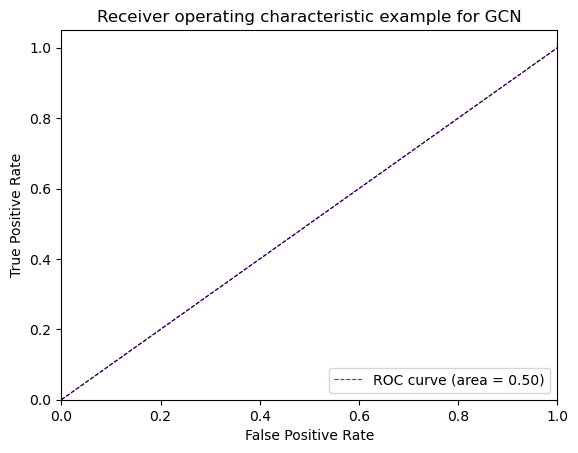

In [23]:
# Testing-loop;

predictions = []
probabilities = []
truths = []

model.eval()
with torch.no_grad():
    for data in tqdm(train_loader): 
        
        # Grab graph 1 inputs
        X_1, Y_1, EI_1  = graph_1.x, graph_1.y, graph_1.edge_index
        B_1 = graph_1.batch

        # Grab graph 2 inputs
        X_2, Y_2, EI_2  = graph_2.x, graph_2.y, graph_2.edge_index
        B_2 = graph_2.batch

        # Compute model outputs
        logits = model(
            x_1=X_1, x_2=X_2, edge_index_1=EI_1, edge_index_2=EI_2,
            batch_1=B_1, batch_2=B_2).flatten()

        acc, pred, probas = binary_acc(logits, Y_1)

        # Append data
        predictions.append(pred)
        probabilities.append(probas)
        truths.append(Y_1)

# Format
p = np.hstack(predictions)
t = np.hstack(truths)
prob = np.array(torch.concat(probabilities))

# AUC/ROC
fpr, tpr, _ = roc_curve(t, prob)
roc_auc = auc(fpr, tpr)

# Plotting
lw = 0.8
plt.figure()
plt.plot(fpr, tpr, "r--", lw=lw, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example for GCN")
plt.legend(loc="lower right")
plt.show()
plt.show()

In [24]:
predictions

[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0., 0., 0., 0., 0., 0.